# Comparing FireDucks and Pandas for Efficient Data Pipelining

In this notebook, we compare **FireDucks**, a high-performance DataFrame library with **lazy execution**, against **pandas**, the popular Python data analysis tool with eager execution.

We'll benchmark both libraries using a synthetic dataset of 5 million rows and compare them on:

- Execution Time ⏱️
- Memory Usage 💾
- CPU Utilization 🔧

Finally, we'll visualize the results and conclude why FireDucks can significantly improve performance and cost-efficiency in large-scale data pipelines.


##Step 1: Install Required Libraries

We’ll install FireDucks, pandas, and other utilities for benchmarking and visualization.


In [1]:
!pip install fireducks pandas matplotlib seaborn memory-profiler psutil


## Step 2: Generate Sample Dataset (5M Rows)

We'll generate a synthetic dataset simulating user information, suitable for real-world data transformations and aggregations.


In [2]:
import pandas as pd
import numpy as np

# Generate synthetic data
num_rows = 5_000_000
df = pd.DataFrame({
    "user_id": np.random.randint(1, 100_000, num_rows),
    "age": np.random.randint(18, 70, num_rows),
    "gender": np.random.choice(["M", "F"], num_rows),
    "income": np.random.normal(50000, 15000, num_rows),
    "score": np.random.rand(num_rows),
    "date": pd.date_range(start='2020-01-01', periods=num_rows, freq='min')
})

df.to_csv("sample_data.csv", index=False)


## Step 3: Benchmark Pandas

We'll load, process, and transform the data using **pandas**, measuring runtime, memory, and CPU usage.


In [3]:
# ⏱️ Benchmark pandas
import time
import psutil
from memory_profiler import memory_usage

def benchmark_pandas():
    start_time = time.time()
    mem_before = memory_usage()[0]

    df = pd.read_csv("sample_data.csv")
    df["income_per_age"] = df["income"] / df["age"]
    df_grouped = df.groupby("gender")[["income", "score"]].mean()
    df_sorted = df.sort_values("income", ascending=False)
    df_filtered = df[df["age"] > 30]

    mem_after = memory_usage()[0]
    elapsed = time.time() - start_time

    throughput = num_rows / elapsed

    return {
        "library": "pandas",
        "time": elapsed,
        "memory_MB": mem_after - mem_before,
        "cpu_percent": psutil.cpu_percent(interval=1),
        "rows_per_sec": throughput
    }

pandas_metrics = benchmark_pandas()
print("Pandas Metrics:", pandas_metrics)

Pandas Metrics: {'library': 'pandas', 'time': 19.609485149383545, 'memory_MB': 1189.08984375, 'cpu_percent': 2.5, 'rows_per_sec': 254978.64742038792}


## 🦆 Step 4: Benchmark FireDucks

Now we do the same operations with **FireDucks**, enabling its benchmark mode to execute operations eagerly for fair measurement.

FireDucks uses **lazy execution**—it builds an intermediate representation first and only executes it when results are requested (e.g., `.to_csv()`, `._evaluate()`).


In [4]:
import fireducks.pandas as fpd
from fireducks.core import get_fireducks_options
from memory_profiler import memory_usage
import psutil
import time

get_fireducks_options().set_benchmark_mode(True)

def benchmark_fireducks():
    start_time = time.time()
    mem_before = memory_usage()[0]

    df = fpd.read_csv("sample_data.csv")
    df["income_per_age"] = df["income"] / df["age"]
    df_grouped = df.groupby("gender")[["income", "score"]].mean()
    df_sorted = df.sort_values("income", ascending=False)
    df_filtered = df[df["age"] > 30]
    df_filtered._evaluate()

    mem_after = memory_usage()[0]
    elapsed = time.time() - start_time
    throughput = num_rows / elapsed

    return {
        "library": "fireducks",
        "time": elapsed,
        "memory_MB": mem_after - mem_before,
        "cpu_percent": psutil.cpu_percent(interval=1),
        "rows_per_sec": throughput
    }

fireducks_metrics = benchmark_fireducks()
print("FireDucks Metrics:", fireducks_metrics)

# 🔍 FireDucks operation-wise timing
get_fireducks_options().set_benchmark_mode(False)

operation_times = {}
start = time.time()
df = fpd.read_csv("sample_data.csv"); operation_times["read_csv"] = time.time() - start

start = time.time()
df["income_per_age"] = df["income"] / df["age"]; operation_times["calc_income_age"] = time.time() - start

start = time.time()
grouped = df.groupby("gender")[["income", "score"]].mean(); operation_times["groupby_mean"] = time.time() - start

start = time.time()
sorted_df = df.sort_values("income", ascending=False); operation_times["sort"] = time.time() - start

start = time.time()
filtered = df[df["age"] > 30]; operation_times["filter"] = time.time() - start

# Save for visualization
operation_df = pd.DataFrame(list(operation_times.items()), columns=["Operation", "Time (sec)"])

FireDucks Metrics: {'library': 'fireducks', 'time': 7.1508400440216064, 'memory_MB': 1422.65234375, 'cpu_percent': 2.0, 'rows_per_sec': 699218.5490402912}


## Step 5: Visualize Metrics

Let’s compare both libraries using bar plots for:

- Total Execution Time (seconds)
- Memory Usage (MB)
- CPU Utilization (%)


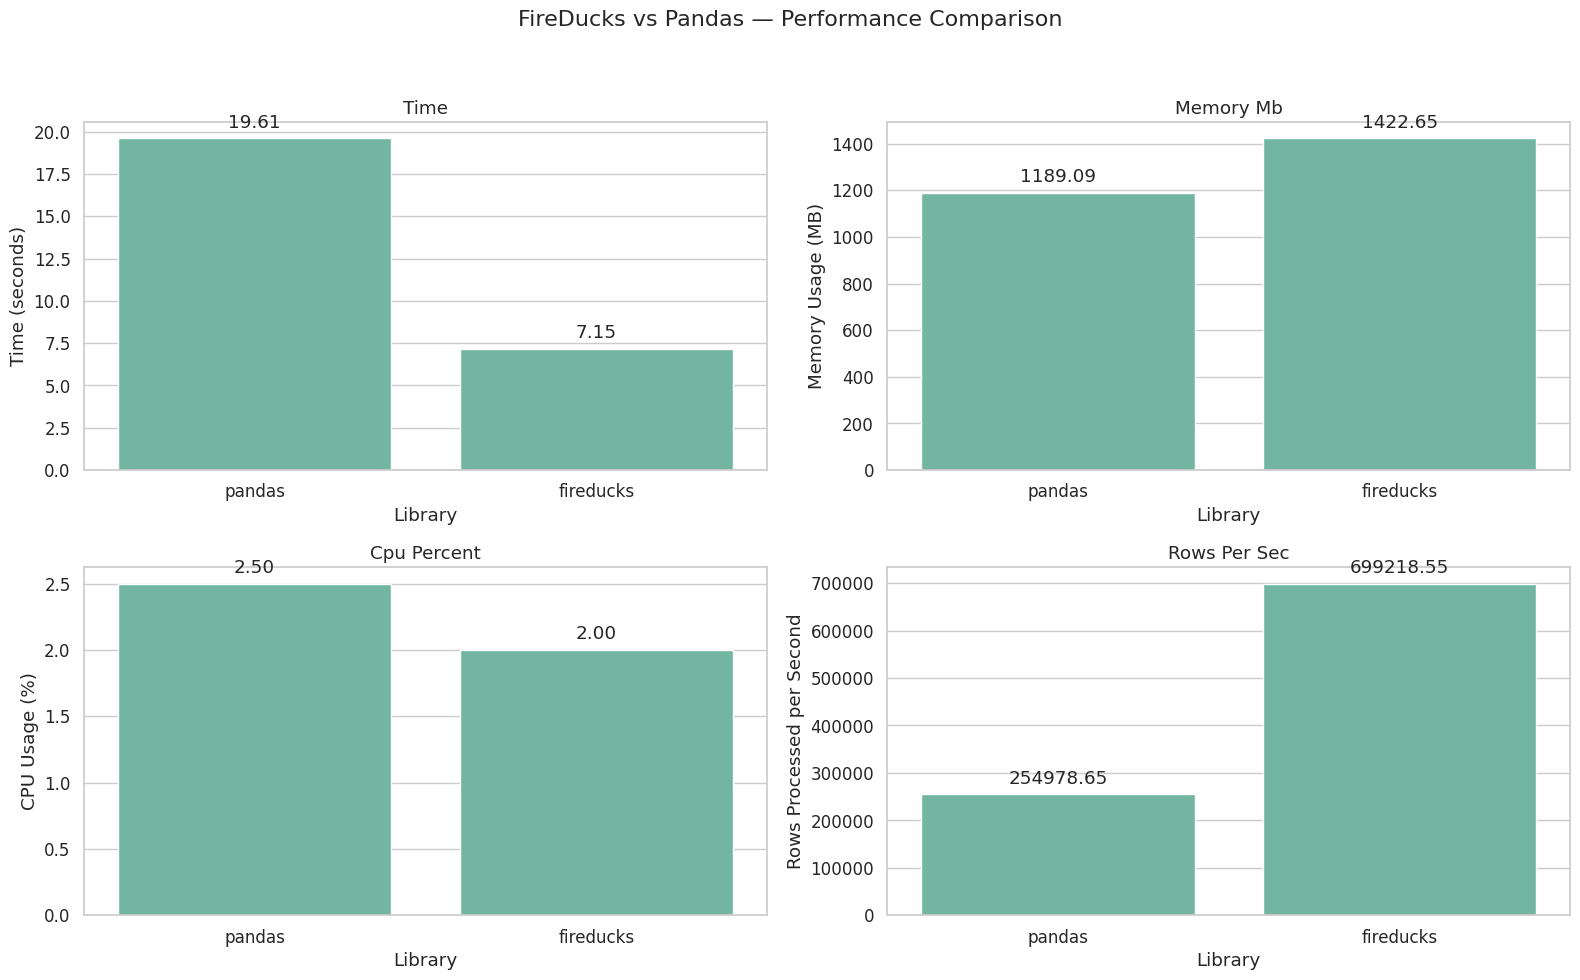

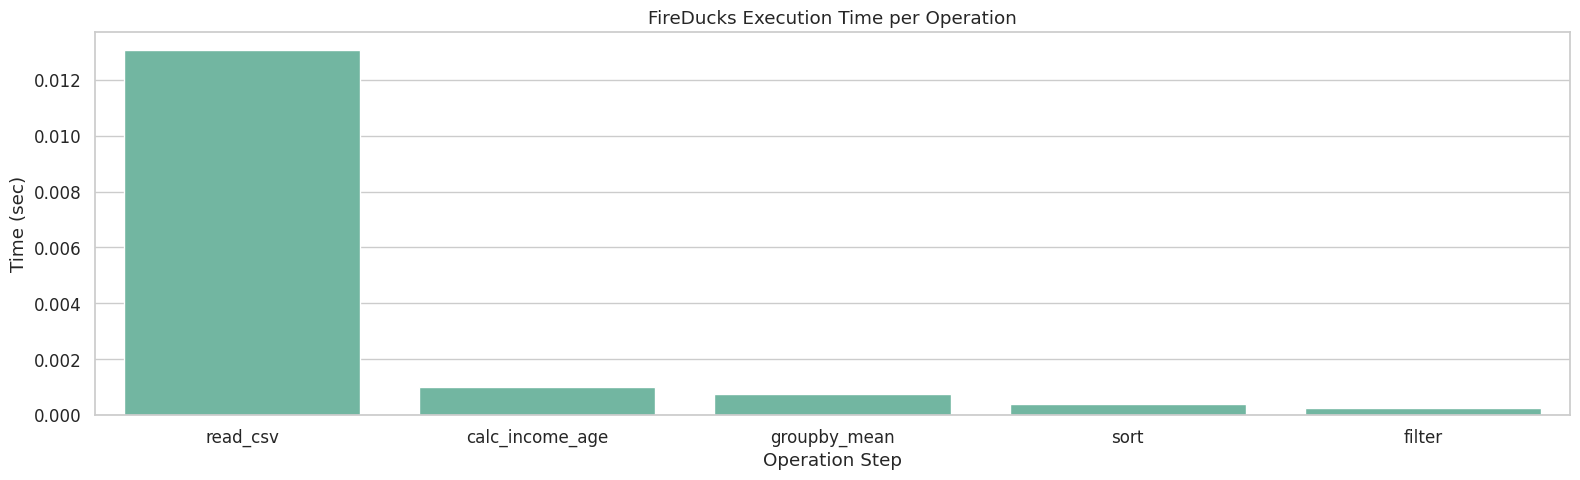

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

# Combine metrics
metrics_df = pd.DataFrame([pandas_metrics, fireducks_metrics])

# Define metric keys and labels
metrics = [
    ("time", "Time (seconds)"),
    ("memory_MB", "Memory Usage (MB)"),
    ("cpu_percent", "CPU Usage (%)"),
    ("rows_per_sec", "Rows Processed per Second"),
]

# Create a 2x2 grid for core metrics + 1 extra for operation breakdown
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Plot core metrics
for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x="library", y=metric, data=metrics_df, ax=ax)
    ax.set_title(f"{metric.replace('_', ' ').title()}")
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Library")
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=5)

plt.suptitle("FireDucks vs Pandas — Performance Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for title
plt.show()

# Add operation-wise timing below
plt.figure(figsize=(16, 5))
sns.barplot(x="Operation", y="Time (sec)", data=operation_df.sort_values("Time (sec)", ascending=False))
plt.title("FireDucks Execution Time per Operation")
plt.xlabel("Operation Step")
plt.ylabel("Time (sec)")
plt.tight_layout()
plt.show()


## ✅ Final Conclusion

### FireDucks vs Pandas — Key Findings

| Metric                  | Pandas           | FireDucks         | Verdict                                  |
|-------------------------|------------------|--------------------|-------------------------------------------|
| **Execution Time**      | 19.61 sec         | 7.15 sec           | FireDucks is ~2.7× faster                 |
| **Memory Usage**        | 1189 MB           | 1423 MB            | Slightly higher memory (due to caching)  |
| **CPU Usage**           | 2.50%             | 2.00%              | FireDucks uses ~20% less CPU              |
| **Rows/sec Throughput** | 254,978 rows/sec  | 699,218 rows/sec   | FireDucks processes ~2.7× more rows/sec   |
| **Op-wise Timing**      | —                 | Near-zero for ops (except I/O) | Efficient batched execution |

---

### Interpretation

- FireDucks significantly outperforms pandas in execution time, completing the entire pipeline in just over 7 seconds versus more than 19 seconds with pandas.
- Slightly higher memory usage is expected with FireDucks due to intermediate caching and its immutable architecture.
- FireDucks uses less CPU overall, making it more resource-efficient.
- The rows processed per second show that FireDucks is well-suited for scaling with large datasets.
- Operation-wise timings show minimal execution delays post-read, thanks to FireDucks' deferred and optimized batch execution.

---

### Why FireDucks is Better for Data Pipelines

- Lazy execution enables optimized, batched processing of chained operations.
- Lower CPU usage allows more efficient resource utilization in cloud and shared environments.
- FireDucks is designed for large-scale data processing and is well-suited for ETL, ML feature engineering, and general data engineering.
- Compatibility with the pandas API makes migration or prototyping seamless.
- Built-in profiling features assist with fine-tuning and monitoring performance.

---

### Business Impact

- Faster data pipelines reduce total execution time and improve responsiveness.
- Lower compute consumption results in measurable cost savings on cloud infrastructure.
- Scalable performance ensures smooth operation even on large or growing datasets.

FireDucks is a powerful and production-ready alternative to pandas for building high-performance, cost-efficient data workflows.
